#### Libraries

In [1]:
#pip install scikit-image

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import glob
import xmltodict
from tensorflow.keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from urllib.request import urlopen
from xml.etree.ElementTree import parse
from numpy import expand_dims
from keras.utils.image_utils import load_img
from keras.utils.image_utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator # load the image
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from matplotlib.colors import LogNorm
from skimage import io
from scipy.signal import convolve2d
from PIL import Image  
import PIL 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import urllib
import xml.etree.ElementTree as ET # copy of xml
from typing import Tuple, List, Dict
from tensorflow.keras import backend as K
from bs4 import BeautifulSoup
from PIL import Image
import requests
from matplotlib import pyplot as plt
from io import BytesIO
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical


In [3]:
 def visualize(**images):
     """PLot images in one row."""
     n = len(images)
     plt.figure(figsize=(16, 5))
     for i, (name, image) in enumerate(images.items()):
         plt.subplot(1, n, i + 1)
         plt.xticks([])
         plt.yticks([])
         plt.title(' '.join(name.split('_')).title())
         plt.imshow(image)
     plt.show()

#### Reading URLs for images and annotations

In [5]:
prefix_url_imgs = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/"
number_of_imgs = 766 # +1 to include last one (765)

list_imgs = []

for i in range(0, number_of_imgs):
    i = str(i)
    var_imgs = "BikesHelmets" + i + ".png"
    var_imgs_url = prefix_url_imgs + var_imgs
    list_imgs.append(var_imgs_url)

#for i in range(0, len(list_imgs)):
#    response = requests.get(list_imgs[i])
#    img = Image.open(BytesIO(response.content))
#    plt.imshow(img)

In [6]:
prefix_url_xml = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/annotations/"
number_of_annt = 766 # +1 to include last one (765)

list_annotations= []

for i in range(0, number_of_annt):
    i = str(i)
    var_annt = "BikesHelmets" + i + ".xml"
    var_annt_url = prefix_url_xml + var_annt
    list_annotations.append(var_annt_url)

#### Labelling images from XML annotations

* Full images

In [91]:
full_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            a = 0
            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            resized = img_temp.resize((224,224)) # resize all images to 224x224
            image = cv2.cvtColor(np.array(resized), cv2.COLOR_BGR2RGB)
            
            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        if i['name'] == 'With Helmet':
                            a =+1
                        else:
                            a =+0
                    if a > 0 :
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else :
                        full_imgs.append([tags['filename'], image, 0, img_path])
                
                if isinstance(tags['object'], dict):
                    if tags['object']['name'] == 'With Helmet':
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else:
                        full_imgs.append([tags['filename'], image, 0, img_path])
            else:
                pass
    except:
        pass

* Mean X and Y of images

In [92]:
x = 0
y = 0
itt = len(full_imgs)
for i in range(0, len(full_imgs)+1):
    try:
        tmp_shape = full_imgs[i][1].shape
        x += tmp_shape[0]
        y += tmp_shape[1]
    except:
        itt -=1
        pass

print(round(x/itt,0))
print(round(y/itt,0))

224.0
224.0


* Transforming images in a proper array for model input

In [162]:
full_imgs_array = []
for i in range(0, len(full_imgs)+1):
    try:
        full_imgs_array.append(np.array(full_imgs[i][1]))
    except:
        pass
full_imgs_array = np.array(full_imgs_array, dtype='int')

In [201]:
# shape of new array
full_imgs_array.shape

(761, 224, 224, 3)

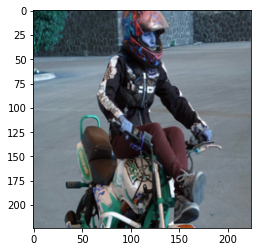

In [205]:
# testing that images appear correctly
plt.imshow(full_imgs_array[1])

In [203]:
# reshape of array
full_imgs_array_rshp = full_imgs_array.reshape(761, 224*224*3)

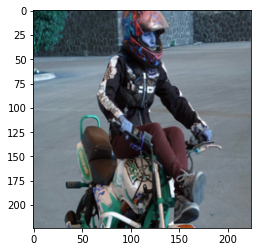

In [204]:
# testing that images appear correctly
plt.imshow(full_imgs_array_rshp[1].reshape(224, 224, 3))

In [167]:
# normalize colors
full_imgs_array_final = full_imgs_array_rshp.astype('float32') / 255

In [206]:
# final shape of input array
full_imgs_array_final.shape

(761, 150528)

* Creating an array with labels for model input

In [176]:
labels_array = []
for i in range(0, len(full_imgs)+1):
    try:
        labels_array.append(np.array(full_imgs[i][2]))
    except:
        pass
labels_array = np.array(labels_array, dtype='int')

* Categorically encode the labels

In [178]:
full_imgs_labels = to_categorical(labels_array)

#### Simple model

In [191]:
# model imports

from tensorflow.keras import models
from tensorflow.keras import layers

In [198]:
network = models.Sequential()

network.add(layers.Dense(512,
                         activation='relu',
                         input_shape=(224 * 224 * 3,)))

network.add(layers.Dense(2,
                         activation='softmax'))

In [199]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [200]:
# We’re now ready to train the network
network.fit(full_imgs_array_final, 
            full_imgs_labels,
            epochs=10,
            batch_size=128,
            validation_split=0.1)

Epoch 1/10
6/6 [==============================] - 7s 1s/step - loss: 317.5047 - accuracy: 0.4503 - val_loss: 13.2836 - val_accuracy: 0.7273
Epoch 2/10
6/6 [==============================] - 6s 1s/step - loss: 11.9244 - accuracy: 0.5760 - val_loss: 12.5282 - val_accuracy: 0.7273
Epoch 3/10
6/6 [==============================] - 6s 1s/step - loss: 9.6237 - accuracy: 0.5863 - val_loss: 9.3740 - val_accuracy: 0.7273
Epoch 4/10
6/6 [==============================] - 6s 984ms/step - loss: 8.1516 - accuracy: 0.5863 - val_loss: 9.6633 - val_accuracy: 0.7273
Epoch 5/10
6/6 [==============================] - 6s 976ms/step - loss: 7.9269 - accuracy: 0.5746 - val_loss: 7.9837 - val_accuracy: 0.7273
Epoch 6/10
6/6 [==============================] - 6s 925ms/step - loss: 7.2442 - accuracy: 0.5716 - val_loss: 8.4373 - val_accuracy: 0.7273
Epoch 7/10
6/6 [==============================] - 6s 968ms/step - loss: 6.8727 - accuracy: 0.5687 - val_loss: 7.7838 - val_accuracy: 0.7273
Epoch 8/10
6/6 [========

* Cropping images with bounding box and labeling

In [82]:
cropped_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            resized = img_temp.resize((28,28)) # resize all images to 28x28
            image = cv2.cvtColor(np.array(resized), cv2.COLOR_BGR2RGB)
            mask = np.zeros(image.shape, dtype = 'int32')

            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        xmin = int(i['bndbox']['xmin'])
                        ymin = int(i['bndbox']['ymin'])
                        xmax = int(i['bndbox']['xmax'])
                        ymax = int(i['bndbox']['ymax'])
                        if i['name'] == 'With Helmet':
                            mask = cv2.rectangle(mask, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                            result = cv2.addWeighted(image, 1, mask, 0.9, 0.7, dtype = cv2.CV_8UC3)
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path])
                            #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                            
                        else:
                            cv2.rectangle(mask, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                            result = cv2.addWeighted(image, 1, mask, 0.9, 0.7, dtype = cv2.CV_8UC3)
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path])
                            
                            #plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                if isinstance(tags['object'], dict):
                    xmin = int(tags['object']['bndbox']['xmin'])
                    ymin = int(tags['object']['bndbox']['ymin'])
                    xmax = int(tags['object']['bndbox']['xmax'])
                    ymax = int(tags['object']['bndbox']['ymax'])
                    if tags['object']['name'] == 'With Helmet':
                        cv2.rectangle(mask, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                        result = cv2.addWeighted(image, 1, mask, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path])
                        #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                    else:
                        cv2.rectangle(mask, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                        result = cv2.addWeighted(image, 1, mask, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path])
                    # plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
            else:
                pass
    except:
        pass

In [83]:
x = 0
y = 0
itt = len(cropped_imgs)
for i in range(0, len(cropped_imgs)+1):
    try:
        tmp_shape = cropped_imgs[i][1].shape
        x += tmp_shape[0]
        y += tmp_shape[1]
    except:
        itt -=1
        pass

print(round(x/itt,0))
print(round(y/itt,0))

46.0
41.0


In [65]:
# Υπάρχουν κάποιες φωτογρασφίες με λάθος τα annotations και για να μην σκάει προς το παρόν

def checking_for_zero_shapes(list):
    for i, label_image in enumerate(list):
        image = np.array(label_image[1]).astype(np.int32)
        if image.shape[0]==0 or image.shape[1]==0:
            list.pop(i)

    return list

In [71]:
# Κάνουμε visualize μία φωτό + reshape, flatten και 0-1

cropped_imgs_cleaned = checking_for_zero_shapes(cropped_imgs)
#imgs_labels.pop(1342) #H prohgoumenh sunarthsh de mporei na bgalei authn thn eikona, de kserw giati
cropped_array = np.array(cropped_imgs_cleaned, dtype='object').reshape(-1,2,1)
    #imgs_labels = np.array(imgs_labels).reshape(-1,2,1)
cropped_array_reshaped = cropped_array[:,0].reshape(-1,1).astype(np.int32)
cropped_flatten = cropped_array_reshaped[:,1].flatten()
cropped_normalized = cropped_flatten/255
imgs = np.array(cropped_normalized)
#print(imgs)

visualize(Sample_Image = imgs[0])

ValueError: invalid literal for int() with base 10: 'BikesHelmets0.png'

#### Augmentantion functions

In [6]:
def picture_zoom(image):
   
   # to array
    array = expand_dims(image[1], 0)

   # create image data augmentation generator
    datagen_zoom= ImageDataGenerator(zoom_range=[0.8,1.5])

    # prepare iterator
    it_zoom = datagen_zoom.flow(array, batch_size=1)

    # generate batch of images
    batch_zoom = it_zoom.next()
    
    # convert to unsigned integers for viewing
    image_zoom = batch_zoom[0].astype('uint64')
    
    # returning list
    list = [image[0], image_zoom, image[2], image[3]]
    return list

In [7]:
def picture_rotation(image):

    # to array
    array = expand_dims(image[1], 0)
   
    # ImageDataGenerator rotation
    datagen_rotation=ImageDataGenerator(rotation_range=45, fill_mode='nearest')

    # prepare iterator
    it_rotation = datagen_rotation.flow(array, batch_size=1)

    # generate batch of images
    batch_rotation = it_rotation.next()
    
    # convert to unsigned integers for viewing
    image_rotation = batch_rotation[0].astype('uint64')

    # plot raw pixel 
    img_rotation=plt.imshow(image_rotation, interpolation ='None', filternorm=True) #spline36, antialiased
    
    # returning list
    list = [image[0], image_rotation, image[2], image[3]]
    return list

In [8]:
def picture_brightness(image):
   
    # to array
    array = expand_dims(image[1], 0)

    # create image data augmentation generator
    datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])

    # prepare iterator
    it_brightness = datagen_brightness.flow(array, batch_size=1)
    
    # generate batch of images
    batch_zoom = it_brightness.next()
    
    # convert to unsigned integers for viewing
    image_brightness = batch_zoom[0].astype('uint64')
    
    # plot raw pixel 
    img_brightness=plt.imshow(image_brightness, interpolation ='None')

    # returning list
    list = [image[0], image_brightness, image[2], image[3]]
    return list

* Augmentantion for full images

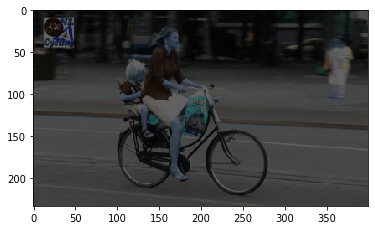

In [9]:
#### Augmentantion of cropped images
augm_full_imgs = []
for i in range(0, len(full_imgs)+1):
    try:
        augm_full_imgs.append(picture_zoom(full_imgs[i]))
        augm_full_imgs.append(picture_rotation(full_imgs[i]))
        augm_full_imgs.append(picture_brightness(full_imgs[i]))
    except:
        pass

In [10]:
final_full_imgs = full_imgs + augm_full_imgs

* Augmentantion for cropped images

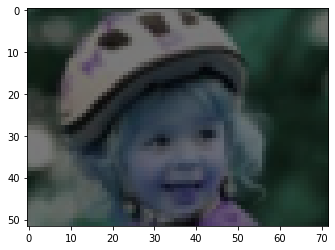

In [288]:
#### Augmentantion of cropped images
augm_cropped_imgs = []
for i in range(0, len(cropped_imgs)+1):
    try:
        augm_cropped_imgs.append(picture_zoom(cropped_imgs[i]))
        augm_cropped_imgs.append(picture_rotation(cropped_imgs[i]))
        augm_cropped_imgs.append(picture_brightness(cropped_imgs[i]))
    except:
        pass

* Append initial cropped images with augmented cropped images

In [310]:
final_cropped_imgs = cropped_imgs + augm_cropped_imgs

In [15]:
def reshape_img_input(x: np.ndarray,
                      img_rows: int = 28,
                      img_cols: int = 28,
                      normalize: bool = True) -> Tuple:
    """
    This function reshapes a n-dimensional numpy array of images into another format.
    Also normalizes the images

    :param x: N-dimensional array containing images
    :param img_rows: The output width of each of the images
    :param img_cols: The output height of each of the images
    :param normalize: Whether to normalize the images or not
    :return: A numpy array with the transformed images and the shape of each observation (image)
    """

    print(f'Original shape of nd-array: {x.shape}')

    if K.image_data_format() == 'channels_first':

        # the channel dimension goes to the front
        x1 = x.reshape(x.shape[0], 1, img_rows, img_cols)

        input_shape = (1, img_rows, img_cols)

    else:
        # the channel dimension goes to the end. So we end up with the following 4-D tensor
        # (N-samples, Height, Width, N-channels)
        x1 = x.reshape(x.shape[0], img_rows, img_cols, 1)

        input_shape = (img_rows, img_cols, 1)

    x1 = x1.astype('float32')

    if normalize:
        x1 /= 255.


    return x1, input_shape